In [49]:
from collections import Counter
from itertools import chain
import pandas as pd
import numpy as np
import psycopg2
import json
import os

In [13]:
con = psycopg2.connect(dbname='gdelt_analysis', user='postgres', password='postgres', host='localhost')
cur = con.cursor()

## Number of Articles for the Terms "Black" & "Hate" Over the Past 3 Years

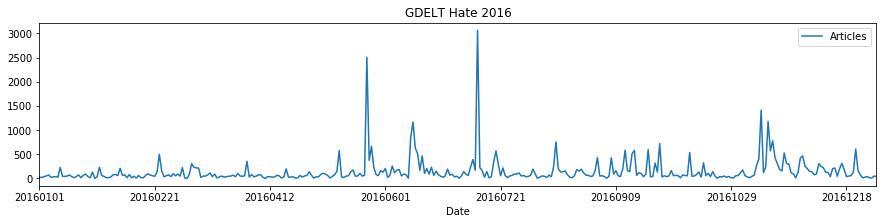

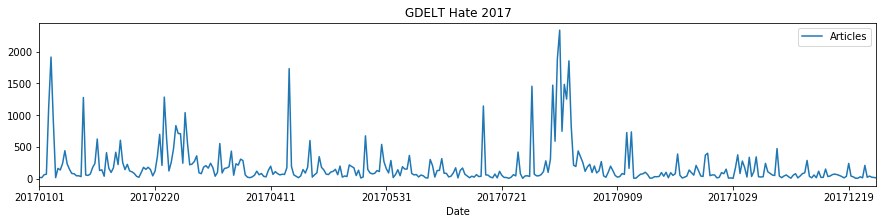

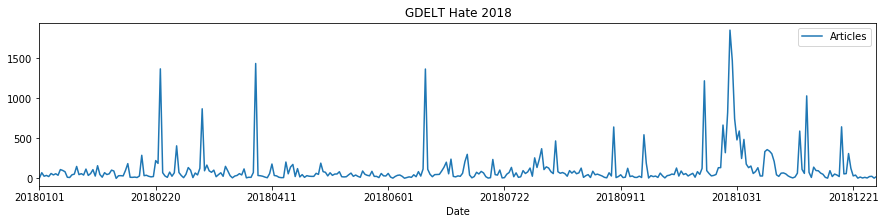

In [14]:
for year in [2016, 2017, 2018]:
    
#     cur.execute('''
#                 select sqldate, sum(numarticles) 
#                 from gdelt_black
#                 where left(sqldate, 4)::integer = {0}
#                 group by sqldate order by sqldate
#                 '''.format(year))
    
#     b_df = pd.DataFrame([r for r in cur.fetchall()], columns=['Date', 'Articles'])
#     b_df.plot(x='Date', y='Articles', figsize=(15, 3), title='GDELT Black {}'.format(year))
    
    cur.execute('''
                select sqldate, sum(numarticles) 
                from gdelt_hate
                where left(sqldate, 4)::integer = {0}
                group by sqldate order by sqldate
                '''.format(year))
    
    h_df = pd.DataFrame([r for r in cur.fetchall()], columns=['Date', 'Articles'])
    h_df.plot(x='Date', y='Articles', figsize=(15, 3), title='GDELT Hate {}'.format(year))


## Explore "Event Windows" Over Time

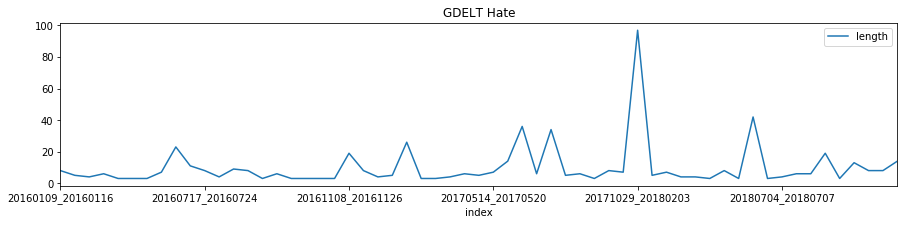

In [15]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()
df.reset_index().plot(x='index', y='length', title='GDELT Hate', figsize=(15, 3))

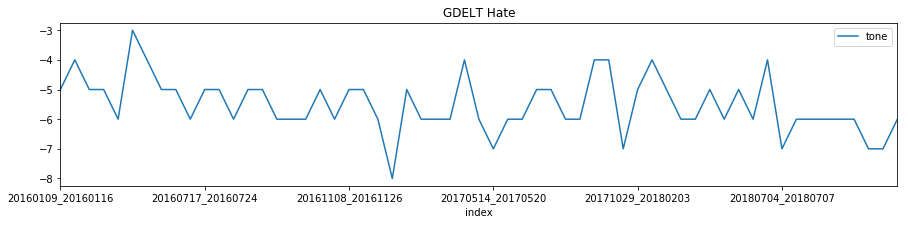

In [16]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()
df.reset_index().plot(x='index', y='tone', title='GDELT Hate', figsize=(15, 3))

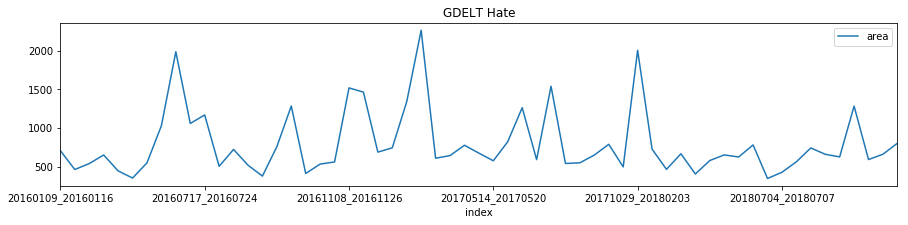

In [17]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()
df.reset_index().plot(x='index', y='area', title='GDELT Hate', figsize=(15, 3))

## Clean & Export "Window" Overview

In [18]:
events = json.load(open('gdelt_hate.json', 'rb'))
df = pd.DataFrame.from_dict(events).transpose()

a_1 = df['actor_one'].apply(pd.Series)
a_1 = a_1.rename(columns = lambda x : 'a1_' + str(x))
df  = pd.concat([df[:], a_1[:]], axis=1)

a_2 = df['actor_two'].apply(pd.Series)
a_2 = a_2.rename(columns = lambda x : 'a2_' + str(x))
df  = pd.concat([df[:], a_2[:]], axis=1)

keys = df['keywords'].apply(pd.Series)
keys = keys.rename(columns = lambda x : 'k_' + str(x))
df  = pd.concat([df[:], keys[:]], axis=1)

df.reset_index(inplace=True)
df.rename(index=str, columns={"index": "start_end"}, inplace=True)

df['start'] = df['start_end'].apply(lambda x: x[:8])
df['end']   = df['start_end'].apply(lambda x: x[-8:])
df['year']  = df['start_end'].apply(lambda x: x[:4])

df['articles'] = df['articles'].astype('int64')
df['length']   = df['length'].astype('int64')
df['area']     = df['area'].astype('int64')
df['tone']     = df['tone'].astype('int64')

df.head()

,start_end,actor_one,actor_two,area,articles,keywords,length,tone,a1_0,a1_1,...,a2_3,a2_4,k_0,k_1,k_2,k_3,k_4,start,end,year
0,20160109_20160116,"[RELIGION, WASHINGTON, PRESIDENT, LOUISIANA, C...","[MALE, WASHINGTON, GOVERNMENT, IRAN, SUICIDE B...",707,519,"[told, muslims, muslim, arrested, terrorist]",8,-5,RELIGION,WASHINGTON,...,IRAN,SUICIDE BOMBER,told,muslims,muslim,arrested,terrorist,20160109,20160116,2016
1,20160127_20160131,"[UTAH, PRESIDENT, MAYOR, UNIVERSITY, SECRETARY...","[UTAH, SERVER, LAW ENFORCEMENT AGENCIES, SOUTH...",464,387,"[sexual, law, gay, state, victims]",5,-4,UTAH,PRESIDENT,...,SOUTH CAROLINA,CRIMINAL,sexual,law,gay,state,victims,20160127,20160131,2016
2,20160222_20160225,"[JEWISH, MALE, COMPANY, ADVOCATE, RESIDENTS]","[PROTESTANT, WASHINGTON, GOVERNMENT, SOUTH CAR...",541,828,"[told, black, students, man, bill]",4,-5,JEWISH,MALE,...,SOUTH CAROLINA,CRIMINAL,told,black,students,man,bill,20160222,20160225,2016
3,20160307_20160312,"[OKLAHOMA, REUTERS, SOUTH CAROLINA, TELEVISION...","[JEWISH, COMPANY, RELIGION, MALE, NURSE]",652,1083,"[center, state, republican, islam, muslims]",6,-5,OKLAHOMA,REUTERS,...,MALE,NURSE,center,state,republican,islam,muslims,20160307,20160312,2016
4,20160401_20160403,"[TROOPER, IMMIGRANT, GUNMAN, CHAD, SCHOOL]","[GUNMAN, LOS ANGELES, ARIZONA, EMPLOYEE, MASSA...",446,443,"[world, republican, cant, debate, fox]",3,-6,TROOPER,IMMIGRANT,...,EMPLOYEE,MASSACHUSETTS,world,republican,cant,debate,fox,20160401,20160403,2016


## 2017 - Average Articles / Event Length

In [19]:
df.groupby('year').agg(['mean', 'max', 'min', 'count'])

area                      articles                       length  \
            mean   max  min count         mean    max  min count       mean   
year                                                                          
2016  796.478261  1988  354    23  1642.391304   7490  259    23   6.695652   
2017  938.722222  2266  498    18  2942.944444  17702  350    18  15.277778   
2018  645.722222  1284  348    18  1594.500000   8130  278    18   8.888889   

                        tone                
     max min count      mean max min count  
year                                        
2016  23   3    23 -5.173913  -3  -6    23  
2017  97   3    18 -5.666667  -4  -8    18  
2018  42   3    18 -5.777778  -4  -7    18

## Unique Keywords

In [20]:
year_df = df[[
    'year', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'a1_0', 'a1_1', 'a1_2', 'a1_3', 'a1_4', 'a2_0', 'a2_1', 'a2_2', 'a2_3', 'a2_4'
]]

year_df.groupby(['year']).nunique()

,year,k_0,k_1,k_2,k_3,k_4,a1_0,a1_1,a1_2,a1_3,a1_4,a2_0,a2_1,a2_2,a2_3,a2_4
year,,,,,,,,,,,,,,,,
2016,1,15,18,22,20,23,15,14,18,17,19,12,16,18,21,18
2017,1,13,15,16,18,14,7,13,10,13,12,8,11,15,14,16
2018,1,11,13,18,18,17,8,14,15,15,12,7,13,17,14,13


## Most Common Keywords

In [21]:
gb = df.groupby(['year', 'k_0'], as_index=False).count()
gb.sort_values('start', inplace=True, ascending=False)
gb = gb[['year', 'k_0', 'start']]
gb[gb.start > 1]

,year,k_0,start
38,2018,white,5
12,2016,white,5
27,2017,white,4
7,2016,officers,2
24,2017,speech,2
31,2018,man,2
11,2016,told,2
6,2016,muslim,2
5,2016,man,2
35,2018,speech,2


In [22]:
year_df = df[[
    'year', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'articles'
]]

year_df.groupby(['year']).agg(['sum'])
year_df.sort_values(['articles', 'year'], ascending=False).head(n=20)

,year,k_0,k_1,k_2,k_3,k_4,articles
34,2017,white,charlottesville,violence,rally,speech,17702
55,2018,synagogue,jewish,shooting,pittsburgh,man,8130
20,2016,election,white,incidents,muslims,state,7490
40,2017,white,speech,man,law,state,7315
24,2017,man,muslim,law,speech,federal,5856
8,2016,orlando,shooting,violence,attack,gay,5288
9,2016,officers,lives,black,dallas,white,4627
23,2017,chicago,man,victim,suspects,video,4027
7,2016,bill,lives,matter,blue,law,3984
32,2017,muslim,center,mosque,man,state,3760


In [23]:
year_df = df[[
    'year', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'articles'
]]

year_df.groupby(['year', 'k_0', 'k_1', 'k_3', 'k_4']).sum()

articles
year k_0         k_1             k_3             k_4                  
2016 bill        lives           blue            law              3984
     center      state           islam           muslims          1083
     church      ad              couple          letter            259
     election    white           muslims         state            7490
     islamic     letter          incidents       reported         1847
     man         hateful         ohio            appeal            356
                 women           law             blue              821
     muslim      set             mosque          man               955
                 state           woman           york              987
     officers    law             baton           2020             1593
                 lives           dallas          white            4627
     orlando     shooting        attack          gay              5288
     school      bill            law             officer           753
     sexual      law             state           victims           387
     told        black           man             bill              828
                 muslims         arrested        terrorist         519
     white       lives           law             movement          648
                 man             clinton         hillary           878
                                                 khalsa            638
                 protesters      charlotte       congressman       728
                 york            folsom          onby              884
     world       republican      debate          fox               443
     york        murder          muslim          shot             1779
2017 bad         military        community       decision          618
     chicago     man             suspects        video            4027
     community   indian          dees            incited           734
     las         speech          harlem          jewish            513
     law         lawmakers       treene          university        812
     man         muslim          speech          federal          5856
     muslim      center          man             state            3760
     portland    university      student         white            2660
     shooting    kansas          threats         white            1246
                 white           muhammad        killed           2147
     speech      community       incidents       free             1068
                 state           jewish          white             350
     transgender man             williamson      federal           790
     university  man             urbanski        maryland          966
     white       charlottesville rally           speech          17702
                 house           transgender     case              722
                 resolution      charlottesville condemning       1687
                 speech          law             state            7315
2018 black       man             bernstein       star             1852
     border      families        melania         policy           1597
     declaration facebook        speech          attack            619
     man         media           border          curiel            589
                 white           york            political        1442
     mosque      man             texas           perez             449
     muslim      san             aghdam          company          1647
     pleads      purinton        kansas          murder            301
     speech      copyright       haters          lyrics            422
                 man             woodbridge      city              278
     state       border          federal         heading          1092
                 white           itthe           late             1971
     synagogue   jewish          pittsburgh      man              8130
     white       man             law             reported         1660
               

In [24]:
year_df = df[[
    'year', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'articles'
]]

year_df.groupby(['year']).sum()
year_df.sort_values('articles', ascending=False)

,year,k_0,k_1,k_2,k_3,k_4,articles
34,2017,white,charlottesville,violence,rally,speech,17702
55,2018,synagogue,jewish,shooting,pittsburgh,man,8130
20,2016,election,white,incidents,muslims,state,7490
40,2017,white,speech,man,law,state,7315
24,2017,man,muslim,law,speech,federal,5856
8,2016,orlando,shooting,violence,attack,gay,5288
9,2016,officers,lives,black,dallas,white,4627
23,2017,chicago,man,victim,suspects,video,4027
7,2016,bill,lives,matter,blue,law,3984
32,2017,muslim,center,mosque,man,state,3760


In [47]:
events = json.load(open('gdelt_hate.json', 'rb'))
total_events = len(events.keys())

white_count = 0
white_count_length = []
other_length = []

for event, attributes in events.items():
    if 'white' in attributes['keywords']:    
#         print(event, attributes['keywords'])
#         print(event, attributes['actor_one'])
#         print('#' * 75)
        white_count += 1
        white_count_length.append(attributes['length'])
    else:
        other_length.append(attributes['length'])
        
print(f'{white_count} of {total_events}')
p = (white_count / total_events) * 100
print(p)
print(np.mean(white_count_length))
print(np.mean(other_length))

25 of 59
42.3728813559322
13.04
7.735294117647059


In [53]:
all_keys = list(chain(*[k['keywords'] for k in events.values()]))
count = Counter(all_keys).most_common(15)
count

[('white', 25),
 ('man', 23),
 ('state', 11),
 ('law', 10),
 ('speech', 10),
 ('muslim', 7),
 ('york', 5),
 ('muslims', 4),
 ('black', 4),
 ('shooting', 4),
 ('attack', 4),
 ('jewish', 4),
 ('bill', 3),
 ('lives', 3),
 ('murder', 3)]